In this notebook, we will compute the number of participants needed to find a significant inhibition effect.

To that aim, we will:

1. compute the response rate after visible and invisible flashes
2. compute the difference between the curves
3. find the point with the largest difference between the curves
4. estimate the effect size and variablility at that point

In [1]:
# Import libraries
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as cls

from math import sqrt
from statsmodels.stats.power import TTestPower

# set colormaps
top = plt.cm.get_cmap('Greens_r', 128)
bottom = plt.cm.get_cmap('Greys', 128)
shiftcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
shiftcmp = cls.ListedColormap(shiftcolors, name='GnGy')
points_cm = plt.cm.Blues(np.linspace(0.2,1,4))


# load the pre-processed data frames
jump_df = pd.read_csv('../data/jump_preprocessed.csv')
serial_df = pd.read_csv('../data/serial_preprocessed.csv')

# we need to manually write out the flash condition (was corrected in the online script)
serial_df['flashShown'] = serial_df.trialID.isin([20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,
                                                  60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79])

# for now, we are not interested in secondary jumps
serial_df = serial_df[serial_df['stimJumped'] == 0.0]

# compute the delay between flash and movement onset
jump_df['SOA'] = jump_df.goTime - jump_df.flashOnTime

# initialize an effect table
effect_table = pd.DataFrame(index=['jump', 'serial'], columns = ['max_tp', 
                                                                 'mean_diff', 'sd_diff',
                                                                 'mean_flash', 'sd_flash', 
                                                                 'mean_noflash','sd_noflash'])

Define useful functions for the analysis below:

In [2]:
# martin's serial inhibition code

def causRate(movOns, wbLock, waLock, nt):
    """

     analyse rate in causal time window

     input:    movOns  - movement onset times
               wbLock  - window before lock
               waLock  - window after lock
               nt      - number of trials
    
     output:   rate    - movement rate
               scale   - time axis
    
    12.12.2005 by Martin Rolfs
    21.06.2021 translated to python by Clara Kuper
    """
    
    # check how many trials these values came from
    if type(nt)==int:
        nt = np.linspace(nt,nt,len(np.arange(-wbLock,waLock, 1)));
    elif len(nt)!=len(np.arange(-wbLock,waLock, 1)):
        error('nt must have the same length as -wbLock:waLock!')

    # alpha defines how much the distribution is shifted
    alpha = 1/20;
    # define empty arrays for scale and rate
    scale = [];
    rate = [];
    
    # loop through all time windows
    for t in np.arange(-wbLock,waLock):
        
        # save the time
        scale.append(t)
        # compute tau
        tau = t-movOns+1/alpha
        # filter tau as event 0/1
        tau = tau[tau>0]
        # get the number of saccades in a given window
        causal = alpha**2*tau*np.exp(-alpha*tau)
        # save the rate 
        rate.append(sum(causal)*1000/nt[len(scale)-1])
    
    return rate, scale

def plot_means_std(rates, scales, ax, cmap, labels):
    
    """
    plot the mean value and standart errors around
    
    INPUT: 
    rates: the values on which error and mean are computed (an array of arrays!)
    scales: the x value against which they are plotted (an array of arrays!)
    ax: the figure axis on which we plot
    cmap: the color scheme to be used
    labels: the labels for the legend
    """
    
    # zip and loop through the arrays
    for rate, scale, c, l in zip(rates,scales, cmap, labels):
        
        # compute mean
        mu = np.array(rate, dtype = np.float64).mean(axis=0)
        # compute error
        sigma = np.array(rate, dtype = np.float64).std(axis=0)
        # plot mean
        ax.plot(scale, mu, lw=1, color = c, label = l)
        # plot error
        ax.fill_between(scale, mu+sigma, mu-sigma, color = c, alpha = 0.5)
        
        
def compute_rate(data, onset_col):
    
    """
    define the number of trials and the time window, compute the movement rate
    
    INPUT:
    data: the data frame with all necessary information
    onset_col: the column with all onset times
    
    OUTPUT:
    rate: the movement rate in each time window (size 1 ms)
    scale: the time steps 
    """
    
    # get the number of trials
    nt = len(np.unique(data.trialID))
    
    # get the window at which we want to look
    window_before = abs(min(0,data[onset_col].min()))
    window_after = abs(max(0,data[onset_col].max()))
    
    # get movement onsets
    rate, scale = causRate(data[onset_col], window_before, window_after, nt)
    
    
    return rate, scale

# multiple rates
def get_rate_per_case(data, case_col, onset_col, winb, wina, nt = None):
    
    """
    loops through conditions in a dataframe (e.g. individual subjects) and computes a movement rate for each.
    INPUT:
    data: the data frame with all necessary colums
    case_col: the column with all conditions
    onset_col: the column with the timing of movement onsets
    winb: the beginning of the time window to look at
    wina: the end of the time window to look at
    nt: the number of trials (if needed to be specified)
    
    OUTPUT:
    rate_list: a list of all computed rates
    scale_list: a list of all computed scales
    cases: the unique entries found in the condition column
    """
    
    # make lists for the rates and scales to save
    rate_list = []
    scale_list = []
    # get all unique cases in the column
    cases = np.unique(data[case_col])  
    
    # loop over all cases
    for c in cases:
        # get case data
        case_data = data[data[case_col] == c] 
        
        # get the number of trials
        if nt == None:
            nt = len(np.unique(case_data.trialID))  
    
        # get movement onsets
        rate, scale = causRate(case_data[onset_col], winb, wina, nt)
        # append to the lists
        rate_list.append(rate)
        scale_list.append(scale)
    
    # return the lists and the case order
    return rate_list, scale_list, cases


def compute_power(effect_table, n_subjects, task):
    
    """
    computes the number of subjects needed for a power level .8 at alpha .05
    
    INPUT: 
    effect_table: a table with the task as index and effect values for each group
    n_subjects: the number of subjects that went into the effect table
    task: the task to be used as an index to the table
    
    OUTPUT:
    nothing, but prints the number of subjects
    """
    
    print('Power analysis for task {}'.format(task))

    # size of samples in pilot study
    n1, n2 = n_subjects, n_subjects

    # variance of samples in pilot study
    s1, s2 = effect_table.loc[task].sd_flash**2, effect_table.loc[task].sd_noflash**2

    # calculate the pooled standard deviation
    # (Cohen's d)
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))

    # means of the samples
    u1, u2 = effect_table.loc[task].mean_flash, effect_table.loc[task].mean_noflash

    # calculate the effect size
    d = (u1 - u2) / s
    print(f'Effect size: {d}')

    # factors for power analysis
    alpha = 0.05
    power = 0.8

    # perform power analysis to find sample size
    # for given effect
    obj = TTestPower()
    n = obj.solve_power(effect_size=d, alpha=alpha, power=power, alternative='two-sided')

    print('Sample size/Number needed in each group: {:.3f}'.format(n))
    
def compute_individual_rates(data):
    
    """
    computes movement rates and scales on a single subject
    
    INPUT:
    data: the filtered data frame
    
    OUTPUT:
    rate: movment rate
    scale: timeline over which the rate was calculated
    """

    onset_col = 'SOA'
    subject_col = 'subject'

    # define a common window 
    # get the window at which we want to look
    window_before = abs(min(0,data[onset_col].min()))
    window_after = abs(max(0,data[onset_col].max()))


    # split the data in flash and no flash trials
    flash = data[data.flashShown == True]
    noflash = data[data.flashShown == False]

    rate_flash, scale_flash, subjects_flash = get_rate_per_case(flash, subject_col, onset_col, window_before, window_after) 
    rate_noflash, scale_noflash, subjects_noflash = get_rate_per_case(noflash, subject_col, onset_col, window_before, window_after) 

    # check 1: all subjects should be the same
    if any(subjects_flash != subjects_noflash):
        print("subject alert")
    else:
        subjects = subjects_flash
        print("subject ok")

    # check 2: all scales should be the same

    if scale_flash != scale_noflash:
        print("scale alert")
    else:
        scale = scale_flash[0]
        print("scale ok")
        
    return rate_flash, rate_noflash, scale, subjects


def plot_individual_rates(rate_flash, rate_noflash, scale, subjects, axs):
    
    """
    plot all movement rates on top of each other
    INPUT:
    rate_flash: list of all rates with flash
    rate_noflash: list of all rates without flash
    scale: one unique scale for all
    subjects: list of all subjects
    axs: the axis on which the figure should be plotted
    
    OUTPUT: nothing, just the plot 
    """

    # define a subject colour map
    cmap_subjects = plt.cm.Blues(np.linspace(0.3, 0.9, len(subjects)))
    c = 0

    for s_id, s in enumerate(subjects):
    
        axs[0].plot(scale, rate_flash[s_id], label = s, c = cmap_subjects[c])
        axs[1].plot(scale, rate_noflash[s_id], label = s, c = cmap_subjects[c])
    
        c+=1

    axs[0].set_title('Flash Visible')
    axs[1].set_title('Flash Invisible') 
    axs[0].set_xlabel('Time after flash (ms)') 
    axs[1].set_xlabel('Time after flash (ms)') 
    axs[0].set_ylabel('Movement rate in Hz')     
    axs[1].legend(loc = [1.2, 0.0], title = 'subject IDs');
    
    

def mean_std_rates(rate_flash, rate_noflash, scale, ax, plot = True):
    
    """
    computes and plots the mean and the standart deviation around on one plot
    INPUT:
    rate_flash: a list of all movement rates with a flash
    rate_noflash: a list of all movment rates without a flash
    scale: one unique scale
    ax: the axis where we want to plot
    plot: default true, if we want to plot or just return the mean and std
    
    OUTPUT:
    mean_flash: the mean over all flashes
    sd_flash: the standard deviatipns over all flashes
    
    mean_noflash: the mean over all no flashes
    sd_noflash: the standard deviation over all no flashes
    """
    
    # get average rates and standard deviation
    # for flash
    mean_flash = np.mean(rate_flash, axis = 0)
    sd_flash = np.std(rate_flash, axis = 0)

    # for no flash
    mean_noflash = np.mean(rate_noflash, axis = 0)
    sd_noflash = np.std(rate_noflash, axis = 0)

    if plot:

        # plot mean
        ax.plot(scale, mean_flash, lw=1, label = 'flash visible', c = 'steelblue')
        ax.plot(scale, mean_noflash, lw=1, label = 'flash invisible', c = 'grey')

        # plot error
        ax.fill_between(scale, mean_flash+sd_flash, mean_flash-sd_flash, alpha = 0.5, color = 'steelblue')
        ax.fill_between(scale, mean_noflash+sd_noflash, mean_noflash-sd_noflash, alpha = 0.5, color = 'grey')

        ax.legend(loc = (1.2, 0))
        ax.set_xlabel('time after flash in ms')
        ax.set_ylabel('movement rate in Hz');
        
    return mean_flash, sd_flash, mean_noflash, sd_noflash



def compute_differences(rate_flash, rate_noflash, subjects, scale, ax, plot = True):
    
    """
    computes and plots the differences between flash and no flash rates
    
    INPUT: 
    rate_flash: a list of movement rates after a flash
    rate_noflash: a list of movement rates after no flash
    subjects: a list of all subjects
    scale: one unique timeline
    ax: the axis where we want to plot
    plot: default = True, if we actually want to plot or just want to compute
    
    OUTPUT:
    mean_flash_difference: the mean of all the rate differneces
    sd_flash_difference: the standard deviation of all the rate differences.
    """
    
    flash_differences = np.array([np.array(rate_flash[x]) - np.array(rate_noflash[x]) for x in range(len(subjects))])

    # find the mean
    mean_flash_difference = flash_differences.mean(axis = 0)

    # and the standard deviation:
    sd_flash_difference = flash_differences.std(axis = 0)

    if plot:

        # plot mean
        ax.plot(scale,mean_flash_difference, lw=1, c = 'lightblue')

        # plot error
        ax.fill_between(scale,mean_flash_difference+sd_flash_difference, mean_flash_difference-sd_flash_difference, alpha = 0.5, color = 'lightblue');
        
        # plot zero line
        ax.plot(scale, np.zeros(len(scale)))
        
        ax.set_title('Visible Flash - Invisible Flash')
        ax.set_xlabel('time after flash in ms')
        ax.set_ylabel('difference between rates in Hz')
        
    return mean_flash_difference, sd_flash_difference

## Analysis 1: Jump task

In [3]:
# 1. compute the movement rates after a flash for every single participant
jump_rate_flash, jump_rate_noflash, jump_scale, jump_subjects = compute_individual_rates(jump_df)

subject ok
scale ok


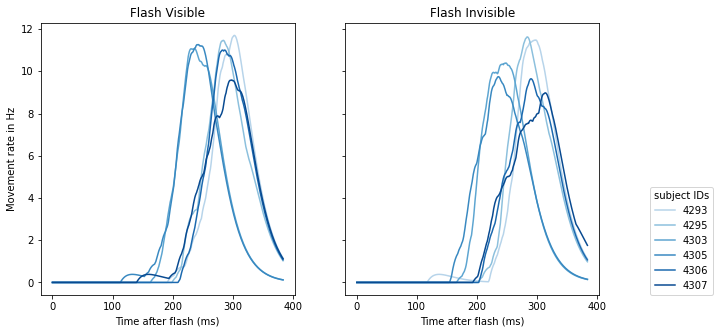

In [4]:
# plot the results
fig_individual_rates_jump, axs_individual_rates_jump = plt.subplots(1,2, figsize = (10,5), sharex = True, sharey = True)
plot_individual_rates(jump_rate_flash, jump_rate_noflash, jump_scale, jump_subjects, axs_individual_rates_jump)

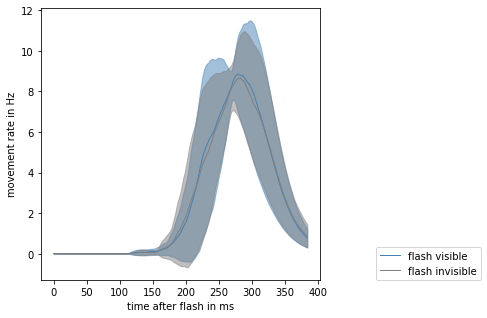

In [5]:
# 2. average over the movement rates
# plot the two curves with standart deviation:
fig_mean_rates_jump, axs_mean_rates_jump = plt.subplots(1,1, figsize = (5,5), sharex = True, sharey = True)
jump_mean_flash, jump_sd_flash, jump_mean_noflash, jump_sd_noflash = mean_std_rates(jump_rate_flash, jump_rate_noflash, jump_scale, axs_mean_rates_jump)

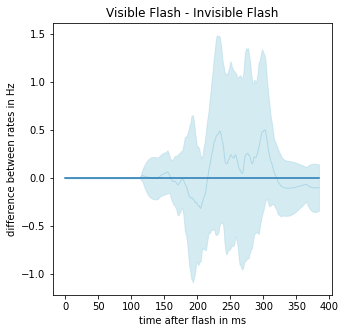

In [6]:
# 3. Individually, compute the difference for rates with and without flash 
fig_differences_jump, axs_differences_jump = plt.subplots(1,1, figsize = (5,5))
jump_mean_difference, jump_sd_difference = compute_differences(jump_rate_flash, jump_rate_noflash, jump_subjects, jump_scale, axs_differences_jump)

In [7]:
# 4. find the maximum value in this distribution - regardless of the direction
pos_max_diff = np.argmax(abs(jump_mean_difference))

In [8]:
# 5. compute the distance and variance at the maximum
effect_table.loc['jump','max_tp'] = jump_scale[pos_max_diff]
effect_table.loc['jump','mean_diff'] = jump_mean_difference[pos_max_diff]
effect_table.loc['jump','sd_diff'] = jump_sd_difference[pos_max_diff]
effect_table.loc['jump','mean_flash'] = jump_mean_flash[pos_max_diff]
effect_table.loc['jump','sd_flash'] = jump_sd_flash[pos_max_diff]
effect_table.loc['jump','mean_noflash'] = jump_mean_noflash[pos_max_diff]
effect_table.loc['jump','sd_noflash'] = jump_sd_noflash[pos_max_diff]

In [9]:
effect_table.loc['jump']

max_tp             302.0
mean_diff       0.503488
sd_diff         0.766994
mean_flash      7.961161
sd_flash        3.396309
mean_noflash    7.457673
sd_noflash      2.907772
Name: jump, dtype: object

In [10]:
# 6. compute the number of subjects needed for a significant effect.
compute_power(effect_table, len(jump_subjects), 'jump')

Power analysis for task jump
Effect size: 0.15925651968480167
Sample size/Number needed in each group: 311.392


## Analysis 2: serial task

In [15]:
# 0. reshape the data frame to have each movement in an individual row

# define the location of the timing columns
time_cols = ['touchOnTime_tar0', 'touchOnTime_tar1', 'touchOnTime_tar2',
            'touchOnTime_tar3', 'touchOnTime_tar4', 'touchOnTime_tar5'] 
# melt the df
molten_serial = pd.melt(serial_df, id_vars = ['subject', 'flashShown', 'flashOnTime', 'trialID'], value_vars=time_cols, 
        var_name='targetID', value_name='timeTouch')
# compute the SOA
molten_serial['SOA'] = molten_serial['timeTouch'] - molten_serial['flashOnTime']

In [16]:
# 1. compute the movement rates after a flash for every single participant
serial_rate_flash, serial_rate_noflash, serial_scale, serial_subjects = compute_individual_rates(molten_serial)

subject ok
scale ok


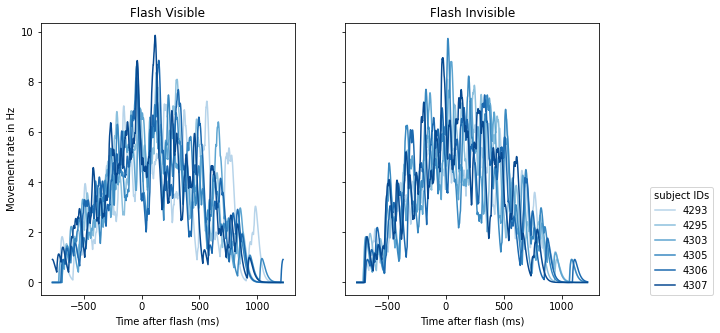

In [17]:
# plot the results
fig_individual_rates_serial, axs_individual_rates_serial = plt.subplots(1,2, figsize = (10,5), sharex = True, sharey = True)
plot_individual_rates(serial_rate_flash, serial_rate_noflash, serial_scale, serial_subjects, axs_individual_rates_serial)

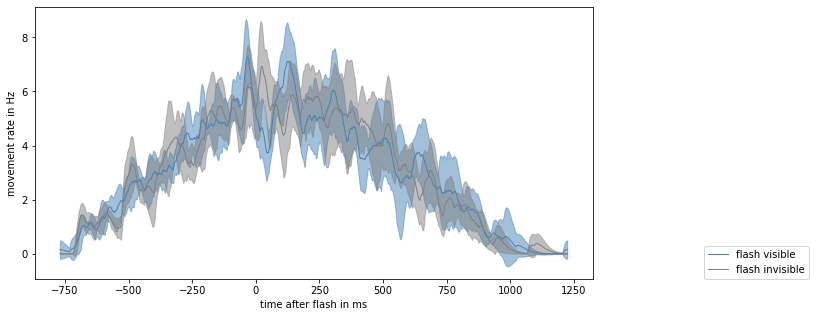

In [18]:
# 2. average over the movement rates
# plot the two curves with standart deviation:
fig_mean_rates_serial, axs_mean_rates_serial = plt.subplots(1,1, figsize = (10,5), sharex = True, sharey = True)
serial_mean_flash, serial_sd_flash, serial_mean_noflash, serial_sd_noflash = mean_std_rates(serial_rate_flash, serial_rate_noflash, serial_scale, axs_mean_rates_serial)

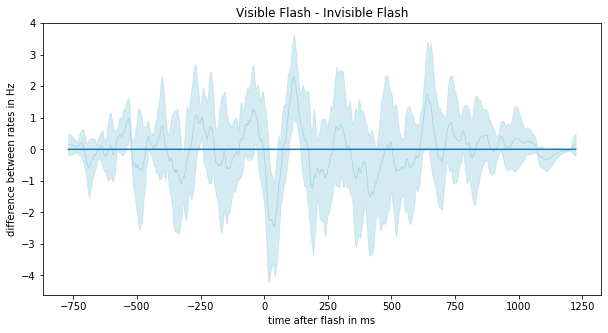

In [19]:
# 3. Individually, compute the difference for rates with and without flash 
fig_differences_serial, axs_differences_serial = plt.subplots(1,1, figsize = (10,5))
serial_mean_difference, serial_sd_difference = compute_differences(serial_rate_flash, serial_rate_noflash, serial_subjects, serial_scale, axs_differences_serial)

In [20]:
# 4. find the maximum value in this distribution - regardless of the direction
pos_max_diff_serial = np.argmax(abs(serial_mean_difference))

In [21]:
# 5. compute the distance and variance at the maximum
effect_table.loc['serial','max_tp'] = serial_scale[pos_max_diff_serial]
effect_table.loc['serial','mean_diff'] = serial_mean_difference[pos_max_diff_serial]
effect_table.loc['serial','sd_diff'] = serial_sd_difference[pos_max_diff_serial]
effect_table.loc['serial','mean_flash'] = serial_mean_flash[pos_max_diff_serial]
effect_table.loc['serial','sd_flash'] = serial_sd_flash[pos_max_diff_serial]
effect_table.loc['serial','mean_noflash'] = serial_mean_noflash[pos_max_diff_serial]
effect_table.loc['serial','sd_noflash'] = serial_sd_noflash[pos_max_diff_serial]

In [22]:
effect_table.loc['serial']

max_tp              40.0
mean_diff      -2.456708
sd_diff         1.503109
mean_flash      3.851157
sd_flash         1.10158
mean_noflash    6.307865
sd_noflash      1.240178
Name: serial, dtype: object

In [23]:
# 6. compute the number of subjects needed for a significant effect.
compute_power(effect_table, len(serial_subjects), 'serial')

Power analysis for task serial
Effect size: -2.0945086486533397
Sample size/Number needed in each group: 4.054
